# Project: Adversarial BayesFlow

In [3]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy
import tensorflow as tf
import tensorflow_probability as tfp
from scipy import stats
from functools import partial



sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.models import GenerativeModel
from bayesflow.diagnostics import true_vs_estimated
from bayesflow.exceptions import ConfigurationError
from bayesflow.applications.priors import GaussianMeanPrior, TPrior, GaussianMeanCovPrior
from bayesflow.applications.simulators import GaussianMeanSimulator, MultivariateTSimulator, GaussianMeanCovSimulator

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices: tf.config.experimental.set_memory_growth(device, True)

# Global setup

In [5]:
def kl_latent_space(z, log_det_J):
    """ Computes the Kullback-Leibler divergence (Maximum Likelihood Loss) between true and approximate
    posterior using simulated data and parameters.
    """

    loss = tf.reduce_mean(0.5 * tf.square(tf.norm(z, axis=-1)) - log_det_J)
    return loss

def maximum_mean_discrepancy(source_samples, target_samples, minimum=0.):
    """ This Maximum Mean Discrepancy (MMD) loss is calculated with a number of different Gaussian kernels.

    """

    sigmas = [
        1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 5, 10, 15, 20, 25, 30, 35, 100,
        1e3, 1e4, 1e5, 1e6
    ]
    gaussian_kernel = partial(_gaussian_kernel_matrix, sigmas=sigmas)
    loss_value = _mmd_kernel(source_samples, target_samples, kernel=gaussian_kernel)
    loss_value = tf.maximum(minimum, loss_value) 
    return loss_value

def _gaussian_kernel_matrix(x, y, sigmas):
    """ Computes a Gaussian Radial Basis Kernel between the samples of x and y.

    We create a sum of multiple gaussian kernels each having a width :math:`\sigma_i`.

    Parameters
    ----------
    x :  tf.Tensor of shape (M, num_features)
    y :  tf.Tensor of shape (N, num_features)
    sigmas : list(float)
        List which denotes the widths of each of the gaussians in the kernel.

    Returns
    -------
    kernel: tf.Tensor
        RBF kernel of shape [num_samples{x}, num_samples{y}]
    """
    def norm(v):
        return tf.reduce_sum(tf.square(v), 1)
    beta = 1. / (2. * (tf.expand_dims(sigmas, 1)))
    dist = tf.transpose(norm(tf.expand_dims(x, 2) - tf.transpose(y)))
    s = tf.matmul(beta, tf.reshape(dist, (1, -1)))
    kernel = tf.reshape(tf.reduce_sum(tf.exp(-s), 0), tf.shape(dist))
    return kernel

def _mmd_kernel(x, y, kernel=_gaussian_kernel_matrix):
    """ Computes the Maximum Mean Discrepancy (MMD) of two samples: x and y.

    Maximum Mean Discrepancy (MMD) is a distance-measure between the samples of the distributions of x and y.

    Parameters
    ----------
    x      : tf.Tensor of shape (num_samples, num_features)
    y      : tf.Tensor of shape (num_samples, num_features)
    kernel : callable, default: _gaussian_kernel_matrix
        A function which computes the kernel in MMD.

    Returns
    -------
    loss : tf.Tensor
        squared maximum mean discrepancy loss, shape (,)
    """

    loss = tf.reduce_mean(kernel(x, x))  # lint error: sigmas unfilled
    loss += tf.reduce_mean(kernel(y, y))  # lint error: sigmas unfilled
    loss -= 2 * tf.reduce_mean(kernel(x, y))  # lint error: sigmas unfilled
    return loss

def mmd_kl_loss(network, *args, mmd_weight=1.0):
    """KL loss in latent z space, MMD loss in summary space."""
    
    # Apply net and unpack 
    x_sum, out = network(*args, return_summary=True)
    z, log_det_J = out
    
    # Apply MMD loss to x_sum
    z_normal = tf.random.normal(x_sum.shape)
    mmd_loss = maximum_mean_discrepancy(x_sum, z_normal)
    
    # Apply KL loss for inference net
    kl_loss = kl_latent_space(z, log_det_J)
    
    # Sum and return losses
    return kl_loss + mmd_weight * mmd_loss

# (1) MVN means
**Task:** Learn means of a 5-variate Gaussian with unit variance.

## Define minimalistic BayesFlow

In [12]:
D = 5

#########

prior = GaussianMeanPrior(D=D)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    1,
    'dense_s1_args': {'activation': 'relu', 'units': 32},
    'dense_s2_args': {'activation': 'relu', 'units': 32},
    'dense_s3_args': {'activation': 'relu', 'units': 32},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=D,
                                   activation_out=None  # linear
                                  )


inference_meta = {
    'n_coupling_layers': 2,
    's_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [32, 32, 32],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': D,
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

In [13]:
trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0007,
                      checkpoint_path='export_ckpt/mmd/means_5D',
                      max_to_keep = 2
                     )

Initializing networks from scratch.


## Converge BayesFlow

In [14]:
losses = trainer.train_rounds(epochs=10, rounds=5, sim_per_round=10000, batch_size=128, n_obs=100)

Simulating initial 10000 data sets...
Converting 10000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 20000
Converting 20000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 30000
Converting 30000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/235 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 40000
Converting 40000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 50000
Converting 50000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

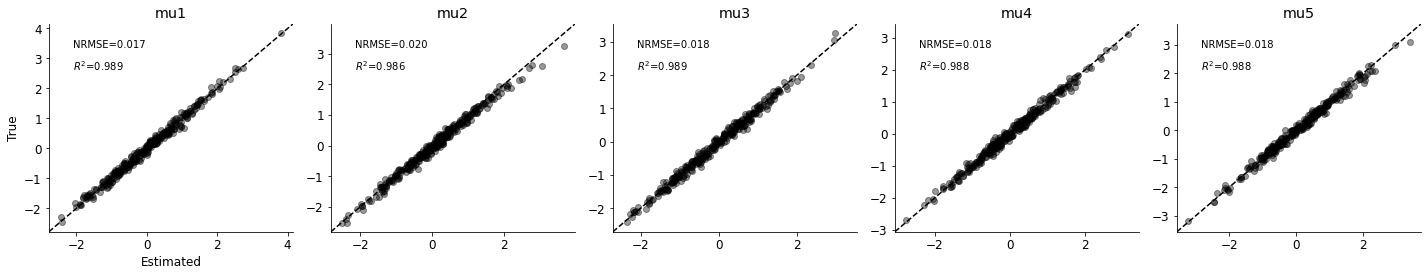

In [17]:
# Validate (quick and dirty)
p, x = trainer._forward_inference(300, 100)
param_samples = trainer.network.sample(x, n_samples=200)
param_means = param_samples.mean(axis=0)
true_vs_estimated(p, param_means, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))

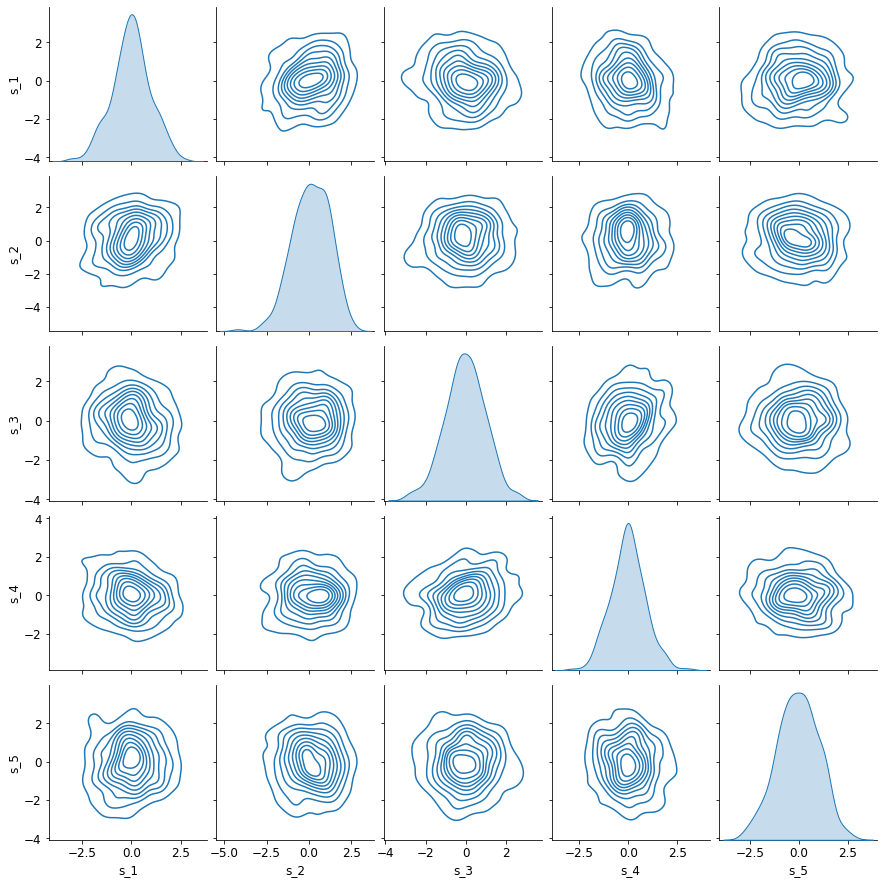

In [18]:
s = np.array(trainer.network.summary_net(x))
sns.pairplot(pd.DataFrame(s, columns=['s_{}'.format(i) for i in range(1, s.shape[1]+1)]), kind="kde")

## Adversarial Tasks

In [ ]:
# Hypersetup for all tasks
D = 5

In [ ]:
def calculate_analytic_posterior(prior, simulator, x):
    n_sim, n_obs, D = x.shape
    
    # Set up variables
    x_bar = np.mean(x, axis=1)                 # empirical mean
    sigma_0 = np.eye(D) * prior.mu_scale       # mu prior covariance
    sigma_0_inv = np.linalg.inv(sigma_0)       # inverse mu prior covariance
    mu_0 = np.ones((D, 1)) * prior.mu_mean     # mu prior mean
    sigma = simulator.sigma                    # likelihood covariance
    sigma_inv = np.linalg.inv(sigma)           # inverse likelihood covariance
    
    mu_posterior_covariance = np.stack([np.linalg.inv(sigma_0_inv + n_obs*sigma_inv)] * n_sim)
    
    mu_posterior_mean = mu_posterior_covariance @ (sigma_0_inv @ mu_0 + n_obs * (sigma_inv @ x_bar[..., np.newaxis]))   
    mu_posterior_mean = mu_posterior_mean.reshape(n_sim, D)

    return mu_posterior_mean, mu_posterior_covariance

In [ ]:
def adversarial_diagnostics(trainer, generative_model, theta=None, x=None, print_pairplot_summarynet=False, print_pairplot_posteriors=False):
    theta, x = generative_model(200, 100) if theta is None and x is None else (theta, x)
    param_samples = trainer.network.sample(x, n_samples=200)
    param_means = param_samples.mean(axis=0)
    
    # true parameters
    print("BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas")
    true_vs_estimated(theta, param_means, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))
    
    # analytic posteriors
    print("\n\nBayesFlow (x) vs. analytic posterior means (y) -- Recovery of analytic posterior means")
    prior = trainer.generative_model.prior.__self__
    simulator = trainer.generative_model.simulator
    posterior_means, posterior_covariances = calculate_analytic_posterior(prior, simulator, x)
    posterior_variances = posterior_covariances.diagonal(axis1=1, axis2=2)
    true_vs_estimated(posterior_means, param_means, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))
    
    print("\n\nAnalytic posterior means (x) vs. true thetas (y)")
    true_vs_estimated(posterior_means, theta, ['mu{}'.format(i) for i in range(1, 5+1)], figsize=(20,4))

    if print_pairplot_summarynet:
        print('\n\nSummary network response for one batch')
        s = np.array(trainer.network.summary_net(x))
        sns.pairplot(pd.DataFrame(s, columns=['s_{}'.format(i) for i in range(1, s.shape[1]+1)]), kind="kde")
        
    if print_pairplot_posteriors:
        print('\n\nFull posterior for one dataset.')
        p = param_samples[0]
        sns.pairplot(pd.DataFrame(p, columns=['dim_{}'.format(i) for i in range(1, p.shape[1]+1)]), kind="kde")

## (A1) Wrong Prior
The prior over the multivariate Gaussian's means is Gaussian: $\mu\sim\mathcal{N}(\mu_\mu, \sigma_\mu)$

During training, the mean's prior was $\mu\sim\mathcal{N}(0, 1)$. This adversarial tasks varies the prior in three steps for the evaluation:

- **(A1)-1** Wrong (free) prior location: $\mu\sim\mathcal{N}(\mu_\mu, 1)$
- **(A1)-2** Wrong (free) prior scale: $\mu\sim\mathcal{N}(0, \sigma_\mu)$
- **(A1)-3** Wrong (free) prior location and scale: $\mu\sim\mathcal{N}(\mu_\mu, \sigma_\mu)$

### (A1)-1 Wrong prior location

In [ ]:
# Posterior wrong, model misspecified

In [ ]:
prior = GaussianMeanPrior(D=D, mu_mean=5, mu_scale=1)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

adversarial_diagnostics(trainer, generative_model)

### (A1)-2 Wrong prior scale

In [ ]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=5)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

adversarial_diagnostics(trainer, generative_model)

### (A1)-3 Wrong prior location and scale

In [ ]:
prior = GaussianMeanPrior(D=D, mu_mean=5, mu_scale=5)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

adversarial_diagnostics(trainer, generative_model)

## (A2) Wrong Likelihood

In [ ]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D, s = 5.0)
generative_model = GenerativeModel(prior, simulator)

adversarial_diagnostics(trainer, generative_model)

In [ ]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D, s = [1, 1, 10, 5, 3])
generative_model = GenerativeModel(prior, simulator)

adversarial_diagnostics(trainer, generative_model, print_pairplot_summarynet=True)

### Wrong likelihood function

In [ ]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = MultivariateTSimulator(df=2)

means = prior(200)
sigma = np.ones_like(means)
theta = np.concatenate((means, sigma), axis=1)
x = simulator(theta, 100)


adversarial_diagnostics(trainer, generative_model=None, theta=theta, x=x)

## (A4) Contamination
$\mathbf{x}_n = \mathbf{x}_n + \xi$

In [ ]:
def normalize(x):
    n_sim, n_obs, data_dim = x.shape
    s = np.std(x, axis=1)
    s_reshaped = s.reshape(n_sim, 1, data_dim).repeat(n_obs, axis=1)
    x_normalized = np.divide(x, s_reshaped)
    return x_normalized

### Pink noise

In this scenario, the contamination $\xi$ is *pink noise* (aka $\frac{1}{f}$ noise) and added to the data $x$. The contaminated data is then normalized to obtain unit variance again.

$\tilde{x}=\dfrac{x+\xi}{\sigma_{x+\xi}}$ with $\xi \sim \frac{1}{f}$

#### Posterior correct, model misspecified

In [ ]:
import colorednoise as cn

prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D)

generative_model = GenerativeModel(prior, simulator)
theta, x = generative_model(200, 100)

lamda = 1.0  # contribution of contamination xi 

xi = cn.powerlaw_psd_gaussian(exponent=1, size=x.shape)

x_tilde = normalize(x + lamda * xi)

adversarial_diagnostics(trainer, generative_model=None, theta=theta, x=x_tilde)

### t Noise
In this scenario, the contamination $\xi$ is $t-$distributed and added to the data $x$. The contaminated data is then normalized to obtain unit variance again.

$\tilde{x}=\dfrac{x+\xi}{\sigma_{x+\xi}}$ with $\xi \sim t_2(0, \mathbb{I})$

In [ ]:
prior = GaussianMeanPrior(D=D, mu_mean=0, mu_scale=1)
simulator = GaussianMeanSimulator(D=D)
generative_model = GenerativeModel(prior, simulator)

theta, x = generative_model(200, 100)

n_sim, n_obs, data_dim = x.shape


lamda = 0.5
xi_theta = np.concatenate((np.zeros((n_sim, data_dim)), np.ones((n_sim, data_dim))), axis=1)
xi_simulator = MultivariateTSimulator(df=2)
xi = xi_simulator(xi_theta, n_obs)

x_tilde = normalize(x + lamda * xi)

adversarial_diagnostics(trainer, generative_model=None, theta=theta, x=x_tilde, print_pairplot_posteriors=True)

# (2) MVN means and full covariance

In [80]:
D = 5

#########

class NormalInverseWishartPrior:
    def __init__(self, D, mu_0=0.0, lamda_0=1.0, Psi_0=None, nu_0=None):
        if Psi_0 is None:
            Psi_0 = np.eye(D)
        if nu_0 is None:
            nu_0 = D+1
        self.D = D,
        self.mu_0 = mu_0
        self.lamda_0 = lamda_0
        self.Psi_0 = Psi_0
        self.nu_0 = nu_0
        
        self.cov_prior = stats.invwishart(self.nu_0, self.Psi_0)
        
    def __call__(self, n_sim):
        cov = self.cov_prior.rvs(n_sim)
        tril_cov = tf.linalg.cholesky((1.0 / self.lamda_0) * cov)
        means = tfp.distributions.MultivariateNormalTriL(self.mu_0, tril_cov).sample()
        
        return np.array(means, dtype=np.float32), np.array(cov, dtype=np.float32)


def param_transform_full_cov(theta):
    means, cov = theta
    means = np.array(means)
    n_sim, D = means.shape
    cov = np.array(cov)
    cov = cov[np.tril(cov).nonzero()].reshape(n_sim, -1)
    return np.concatenate([means, cov], axis=1)


mu_0 = 0.0
lamda_0 = 5
Psi_0 = np.eye(D)
nu_0 = 10
prior = NormalInverseWishartPrior(D=D, mu_0=mu_0, lamda_0=lamda_0, Psi_0=Psi_0, nu_0=nu_0)
simulator = GaussianMeanCovSimulator()
generative_model = GenerativeModel(prior, simulator, param_transform=param_transform_full_cov)

#########

summary_meta = {
    'n_dense_s1': 2,
    'n_dense_s2': 2,
    'n_dense_s3': 2,
    'n_equiv':    2,
    'dense_s1_args': {'activation': 'relu', 'units': 64},
    'dense_s2_args': {'activation': 'relu', 'units': 64},
    'dense_s3_args': {'activation': 'relu', 'units': 64},
}

class BottleneckSummaryNet(tf.keras.Model):
    def __init__(self, inv_meta={}, n_out=10, activation_out=None):
        super(BottleneckSummaryNet, self).__init__()

        self.invariant_net = InvariantNetwork(inv_meta)
        self.out_layer = tf.keras.layers.Dense(n_out, activation=activation_out)
    
    def __call__(self, x):
        out_inv = self.invariant_net(x)
        out = self.out_layer(out_inv)
        return out


summary_net = BottleneckSummaryNet(inv_meta=summary_meta, 
                                   n_out=(sum(range(1, D+1)) + D),  
                                   activation_out=None  # linear
)


inference_meta = {
    'n_coupling_layers': 4,
    's_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [128, 128],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'n_params': sum(range(1, D+1)) + D,   # lower diagonal cov (1+2+...+D) and D means
    'alpha': 1.9,
    'permute': True
}

inference_net = InvertibleNetwork(inference_meta)

amortizer = SingleModelAmortizer(inference_net, summary_net)

trainer = ParameterEstimationTrainer(amortizer,
                      generative_model,
                      loss=mmd_kl_loss,
                      learning_rate=0.0005,
                      checkpoint_path='export_ckpt/mmd/full_cov_5D',
                      max_to_keep = 2
                     )

Initializing networks from scratch.


In [81]:
losses = trainer.train_rounds(epochs=10, rounds=10, sim_per_round=10000, batch_size=128, n_obs=100)

Simulating initial 10000 data sets...
Converting 10000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/79 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/79 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 20000
Converting 20000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/157 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 30000
Converting 30000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/235 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/235 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 40000
Converting 40000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/313 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/313 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 50000
Converting 50000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/391 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/391 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 60000
Converting 60000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/469 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/469 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 70000
Converting 70000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/547 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/547 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 80000
Converting 80000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/625 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/625 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 90000
Converting 90000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/704 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/704 [00:00<?, ?it/s]

Simulating new 10000 data sets and appending to previous...
New total number of simulated data sets: 100000
Converting 100000 simulations to a TensorFlow data set...


Training epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/782 [00:00<?, ?it/s]

In [82]:
def param_list_to_mean_cov(theta, D):
    # setup
    n_sim = theta.shape[0]
    mean = theta[:, :D]
    cov_list = theta[:, D:]
    tril_idx1, tril_idx2 = np.tril_indices(D)
    cov = np.zeros((n_sim, D, D))
    
    # fill cov matrix
    for i in range(n_sim):
        # write from flattened array into in lower triangular matrix
        cov[i, tril_idx1, tril_idx2] = cov_list[i, :]
        
        # mirror lower triangular matrix to upper triangle
        cov[i] = cov[i] + cov[i].T - np.diag(np.diag(cov[i]))
    return mean, cov

def cov_to_corr(cov, std_devs_on_diagonal=True, epsilon=1e-6):
    corr = np.zeros_like(cov)
    n_sim = cov.shape[0]
    
    for i in range(n_sim):
        # extract 2D matrix
        Sigma = cov[i, :, :]
        
        # transform 2D cov matrix into corr matrix
        std_devs = np.sqrt(np.maximum(np.diag(Sigma), epsilon))
        Dinv = np.diag(1 / std_devs)
        corr[i] = Dinv @ Sigma @ Dinv
        
        # increase information by putting SDs on diagonal instead of 1's
        if std_devs_on_diagonal:
            np.fill_diagonal(corr[i], std_devs)
            
    return corr

def theta_cov_to_corr(theta, D):
    mean, cov = param_list_to_mean_cov(theta, D=D)
    corr = cov_to_corr(cov)
    theta_corr = param_transform_full_cov((mean, corr))
    return theta_corr

def true_vs_estimated_tril(theta_true, theta_est, param_names, D, dpi=300,
                      figsize=(20, 4), show=True, filename=None, font_size=12):
    """ Plots a scatter plot with abline of the estimated posterior means vs true values.

    Parameters
    ----------
    theta_true: np.array
        Array of true parameters.
    theta_est: np.array
        Array of estimated parameters.
    param_names: list
        List of parameter names for plotting.
    D : int
        Number of dimensions of parameters.
    dpi: int, default:300
        Dots per inch (dpi) for the plot.
    figsize: tuple(int, int), default: (20,4)
        Figure size.
    show: boolean, default: True
        Controls if the plot will be shown
    filename: str, default: None
        Filename if plot shall be saved
    font_size: int, default: 12
        Font size

    """
    
    idx = 0

    # Plot settings
    plt.rcParams['font.size'] = font_size

    # Determine n_subplots dynamically
    n_row = D+1
    n_col = D

    # Initialize figure
    f, axarr = plt.subplots(n_row, n_col, figsize=figsize)
        
    # --- Plot true vs estimated posterior means on a single row --- #
    
    for i in range(n_row):
        for j in range(n_col):
            if j>(i-1) and i != 0:
                axarr[i, j].axis('off')
            else:
                # Plot analytic vs estimated
                axarr[i, j].scatter(theta_est[:, idx], theta_true[:, idx], color='black', alpha=0.4)

                # get axis limits and set equal x and y limits
                lower_lim = min(axarr[i, j].get_xlim()[0], axarr[i, j].get_ylim()[0])
                upper_lim = max(axarr[i, j].get_xlim()[1], axarr[i, j].get_ylim()[1])
                axarr[i, j].set_xlim((lower_lim, upper_lim))
                axarr[i, j].set_ylim((lower_lim, upper_lim))
                axarr[i, j].plot(axarr[i, j].get_xlim(), axarr[i, j].get_xlim(), '--', color='black')

                # Compute NRMSE
                rmse = np.sqrt(np.mean( (theta_est[:, idx] - theta_true[:, idx])**2 ))
                nrmse = rmse / (theta_true[:, idx].max() - theta_true[:, idx].min())
                axarr[i, j].text(0.1, 0.9, 'NRMSE={:.3f}'.format(nrmse),
                             horizontalalignment='left',
                             verticalalignment='center',
                             transform=axarr[i, j].transAxes,
                             size=10)

                # Compute R2
                #r2 = r2_score(theta_true[:, j], theta_est[:, j])
                #axarr[j].text(0.1, 0.8, '$R^2$={:.3f}'.format(r2),
                #             horizontalalignment='left',
                #             verticalalignment='center',
                #             transform=axarr[j].transAxes, 
                #             size=10)

                if j == 0 and i == 0 or 0==0:
                    # Label plot
                    axarr[i, j].set_xlabel('Estimated')
                    axarr[i, j].set_ylabel('True')
                axarr[i, j].set_title(param_names[idx])
                axarr[i, j].spines['right'].set_visible(False)
                axarr[i, j].spines['top'].set_visible(False)
                
                idx += 1
    
    # Adjust spaces
    f.tight_layout()

    if show:
        plt.show()

    if filename is not None:
        f.savefig(filename)

BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas


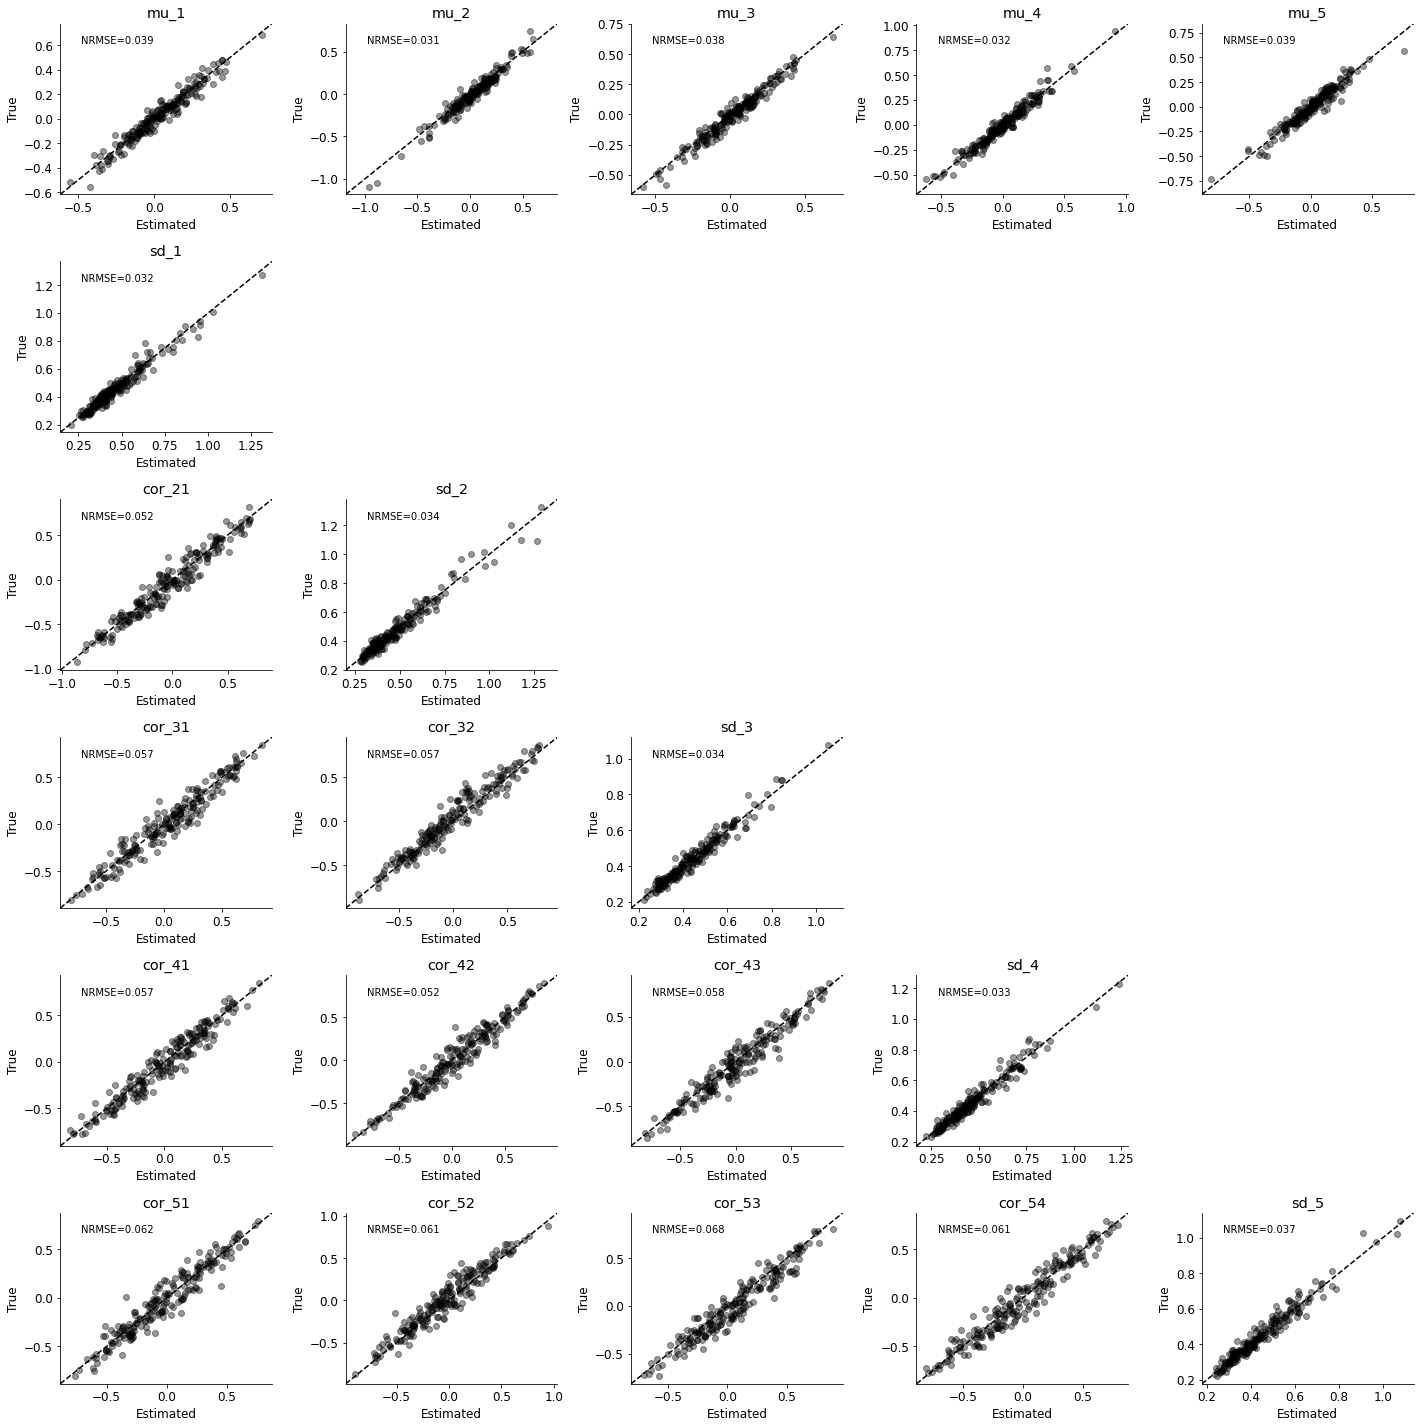

In [83]:
theta, x = generative_model(200, 100)
param_samples = trainer.network.sample(x, n_samples=200)
param_means = param_samples.mean(axis=0)

theta = theta_cov_to_corr(theta, D=D)
param_means = theta_cov_to_corr(param_means, D=D)

param_names = ['mu_{}'.format(i) for i in range(1, D+1)] + \
['sd_{}'.format(i+1) if i==j else 'cor_{}{}'.format(i+1, j+1) for (i, j) in zip(*np.tril_indices(D))]

# true parameters
print("BayesFlow (x) vs. true thetas (y) -- Recovery of true thetas")
true_vs_estimated_tril(theta, param_means, param_names, D, figsize=(20,20))

#print('\n\nSummary network response for one batch')
#s = np.array(trainer.network.summary_net(x))
#sns.pairplot(pd.DataFrame(s, columns=['s_{}'.format(i) for i in range(1, s.shape[1]+1)]), kind="kde")

#print('\n\nFull posterior for one dataset.')
#p = param_samples[0]
#sns.pairplot(pd.DataFrame(p, columns=['dim_{}'.format(i) for i in range(1, p.shape[1]+1)]), kind="kde")

### Analytic posterior

In [ ]:
def analytic_joint_posterior_normal_inverse_wishart(X, mu_0, lamda_0, Psi_0, nu_0):
    n_sim, n_obs, D = X.shape
    mu_n = [None] * n_sim
    lamda_n = [None] * n_sim
    Psi_n = [None] * n_sim
    nu_n = [None] * n_sim
    
    for i in range(n_sim):
        x = X[i, :, :]
        x_bar = np.mean(x, axis=0)
        C = np.dot((x-x_bar).T, x-x_bar)
        
        mu_n[i] = (lamda_0 * mu_0 + n_obs*x_bar) / (lamda_0 + n_obs)
        lamda_n[i] = lamda_0 + n_obs
        nu_n[i] = nu_0 + n_obs
        Psi_n[i] = Psi_0 + C + ((lamda_0*n_obs)/(lamda_0+n_obs)) * np.dot(x_bar-mu_0, (x_bar-mu_0).T)
        
    return mu_n, lamda_n, Psi_n, nu_n


def marginal_posterior_normal_inverse_wishart(mu_n, lamda_n, Psi_n, nu_n):
    D = mu_n[0].shape[0]
    n_sim = len(mu_n)
    
    marginal_mu_distributions = [None] * n_sim
    marginal_Sigma_distributions = [None] * n_sim

    for i in range(n_sim):
        # mu_p
        marginal_mu_distributions[i] = stats.multivariate_t(
            loc=mu_n[i], 
            shape=np.linalg.inv(Psi_n[i]) / (lamda_n[i]*(nu_n[i] - D + 1)), 
            df=nu_n[i] - D + 1
        )
        
        # Sigma_p
        marginal_Sigma_distributions[i] = stats.invwishart(nu_n[i], Psi_n[i])
    
    return marginal_mu_distributions, marginal_Sigma_distributions

In [ ]:
theta, x = generative_model(200, 100)
param_samples = trainer.network.sample(x, n_samples=200)
param_means = param_samples.mean(axis=0)

param_means = theta_cov_to_corr(param_means, D=D)


mu_n, lamda_n, Psi_n, nu_n = analytic_joint_posterior_normal_inverse_wishart(x, mu_0, lamda_0, Psi_0, nu_0)

marginal_mu_p, marginal_Sigma_p = marginal_posterior_normal_inverse_wishart(mu_n, lamda_n, Psi_n, nu_n)

mu_p_means = np.array([dist.loc for dist in marginal_mu_p])
Sigma_p_covs = np.array([dist.scale for dist in marginal_Sigma_p])

theta_analytical_posterior = param_transform_full_cov((mu_p_means, Sigma_p_covs))
theta_analytical_posterior = theta_cov_to_corr(theta_analytical_posterior, D=D)

param_names = ['mu_{}'.format(i) for i in range(1, D+1)] + \
['sd_{}'.format(i+1) if i==j else 'cor_{}{}'.format(i+1, j+1) for (i, j) in zip(*np.tril_indices(D))]

# true parameters
print("BayesFlow (x) vs. true thetas (y) -- Recovery of analytical posteriors")
true_vs_estimated_tril(theta_analytical_posterior, param_means, param_names, D, figsize=(20,20))